# Import Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os, glob
import splitfolders
from PIL import Image
from statistics import median, mean
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l1_l2
import random
from tensorflow.keras.applications import MobileNetV2, DenseNet201

from matplotlib.image import imread
import cv2

import warnings

# Data Loading

In [2]:
dir = 'dataset_padang_food'
items = os.listdir(dir)
items

['ayam_goreng',
 'ayam_pop',
 'daging_rendang',
 'dendeng_batokok',
 'gulai_ikan',
 'gulai_tambusu',
 'gulai_tunjang',
 'telur_balado',
 'telur_dadar']

In [3]:
#create variables by defining the location of the raw dataset folder and the splitting dataset folder

dataraw = 'dataset_padang_food'
datasplit = 'datasplit'

In [7]:
#split dataset with ratio of 70% train data, 20% validation data and 10% test data using splitfolders

splitfolders.ratio(dataraw, output=datasplit, seed=1200, ratio=(.7,.2,.1), group_prefix=None)

Copying files: 993 files [00:23, 42.40 files/s]


In [9]:
#result of splitting dataset

items_splitting = os.listdir(datasplit)
items_splitting

['test', 'train', 'val']

In [26]:
# create directory list

train_path = 'datasplit/train/'
test_path = 'datasplit/test/'
val_path = 'datasplit/val/'
items = os.listdir(train_path)
items

['ayam_goreng',
 'ayam_pop',
 'daging_rendang',
 'dendeng_batokok',
 'gulai_ikan',
 'gulai_tambusu',
 'gulai_tunjang',
 'telur_balado',
 'telur_dadar']

In [27]:
food_path = {
    'Ayam Goreng': 'train/ayam_goreng',
    'Ayam Pop': 'train/ayam_pop',
    'Daging Rendang': 'train/daging_rendang',
    'Dendeng Batokok': 'train/dendeng_batokok',
    'Gulai Ikan': 'train/gulai_ikan',
    'Gulai Tambusu': 'train/gulai_tambusu',
    'Gulai Tunjang': 'train/gulai_tunjang',
    'Telur Balado': 'train/telur_balado',
    'Telur Dadar': 'train/telur_dadar',
    
}

base_path = 'datasplit'

for cuisine, path in food_path.items():
    full_path = os.path.join(base_path, path)
    class_count = len(os.listdir(full_path))
    print(f'There are {class_count} images of the {cuisine} shoes in the data')

There are 74 images of the Ayam Goreng shoes in the data
There are 79 images of the Ayam Pop shoes in the data
There are 72 images of the Daging Rendang shoes in the data
There are 76 images of the Dendeng Batokok shoes in the data
There are 77 images of the Gulai Ikan shoes in the data
There are 72 images of the Gulai Tambusu shoes in the data
There are 83 images of the Gulai Tunjang shoes in the data
There are 77 images of the Telur Balado shoes in the data
There are 81 images of the Telur Dadar shoes in the data


In [28]:
food_path = {
    'Ayam Goreng': 'test/ayam_goreng',
    'Ayam Pop': 'test/ayam_pop',
    'Daging Rendang': 'test/daging_rendang',
    'Dendeng Batokok': 'test/dendeng_batokok',
    'Gulai Ikan': 'test/gulai_ikan',
    'Gulai Tambusu': 'test/gulai_tambusu',
    'Gulai Tunjang': 'test/gulai_tunjang',
    'Telur Balado': 'test/telur_balado',
    'Telur Dadar': 'test/telur_dadar',
    
}

base_path = 'datasplit'

for cuisine, path in food_path.items():
    full_path = os.path.join(base_path, path)
    class_count = len(os.listdir(full_path))
    print(f'There are {class_count} images of the {cuisine} shoes in the data')

There are 12 images of the Ayam Goreng shoes in the data
There are 12 images of the Ayam Pop shoes in the data
There are 12 images of the Daging Rendang shoes in the data
There are 12 images of the Dendeng Batokok shoes in the data
There are 12 images of the Gulai Ikan shoes in the data
There are 11 images of the Gulai Tambusu shoes in the data
There are 13 images of the Gulai Tunjang shoes in the data
There are 12 images of the Telur Balado shoes in the data
There are 12 images of the Telur Dadar shoes in the data


In [29]:
food_path = {
    'Ayam Goreng': 'val/ayam_goreng',
    'Ayam Pop': 'val/ayam_pop',
    'Daging Rendang': 'val/daging_rendang',
    'Dendeng Batokok': 'val/dendeng_batokok',
    'Gulai Ikan': 'val/gulai_ikan',
    'Gulai Tambusu': 'val/gulai_tambusu',
    'Gulai Tunjang': 'val/gulai_tunjang',
    'Telur Balado': 'val/telur_balado',
    'Telur Dadar': 'val/telur_dadar',
    
}

base_path = 'datasplit'

for cuisine, path in food_path.items():
    full_path = os.path.join(base_path, path)
    class_count = len(os.listdir(full_path))
    print(f'There are {class_count} images of the {cuisine} shoes in the data')

There are 21 images of the Ayam Goreng shoes in the data
There are 22 images of the Ayam Pop shoes in the data
There are 20 images of the Daging Rendang shoes in the data
There are 21 images of the Dendeng Batokok shoes in the data
There are 22 images of the Gulai Ikan shoes in the data
There are 20 images of the Gulai Tambusu shoes in the data
There are 23 images of the Gulai Tunjang shoes in the data
There are 22 images of the Telur Balado shoes in the data
There are 23 images of the Telur Dadar shoes in the data


# Exploratory Data Analysis (EDA)

In [30]:
IMG_SIZE = 400
path = 'datasplit/train/'

datagen = tf.keras.preprocessing.image.ImageDataGenerator()
data = datagen.flow_from_directory(path, (IMG_SIZE,IMG_SIZE), batch_size=32, class_mode='categorical', shuffle=True)

Found 691 images belonging to 9 classes.


In [31]:
data.next()

(array([[[[ 97.,  82.,  49.],
          [106.,  91.,  62.],
          [108.,  93.,  70.],
          ...,
          [176., 160., 144.],
          [175., 159., 143.],
          [174., 158., 142.]],
 
         [[ 99.,  84.,  51.],
          [107.,  92.,  63.],
          [111.,  96.,  73.],
          ...,
          [176., 160., 144.],
          [175., 159., 143.],
          [174., 158., 142.]],
 
         [[100.,  85.,  52.],
          [108.,  93.,  64.],
          [115., 100.,  77.],
          ...,
          [178., 162., 146.],
          [178., 162., 146.],
          [177., 161., 145.]],
 
         ...,
 
         [[182., 168., 142.],
          [183., 169., 143.],
          [184., 170., 144.],
          ...,
          [172., 161., 143.],
          [160., 148., 122.],
          [163., 150., 118.]],
 
         [[183., 169., 143.],
          [183., 169., 143.],
          [184., 170., 144.],
          ...,
          [161., 150., 132.],
          [158., 146., 120.],
          [161., 148., 116.

In [32]:
train_dir = []
test_dir = []
validation_dir = []
for item in items :
  train_dir.append(train_path + '/' + item + '/')
  test_dir.append(test_path + '/' + item + '/')
  validation_dir.append(val_path + '/' + item + '/')

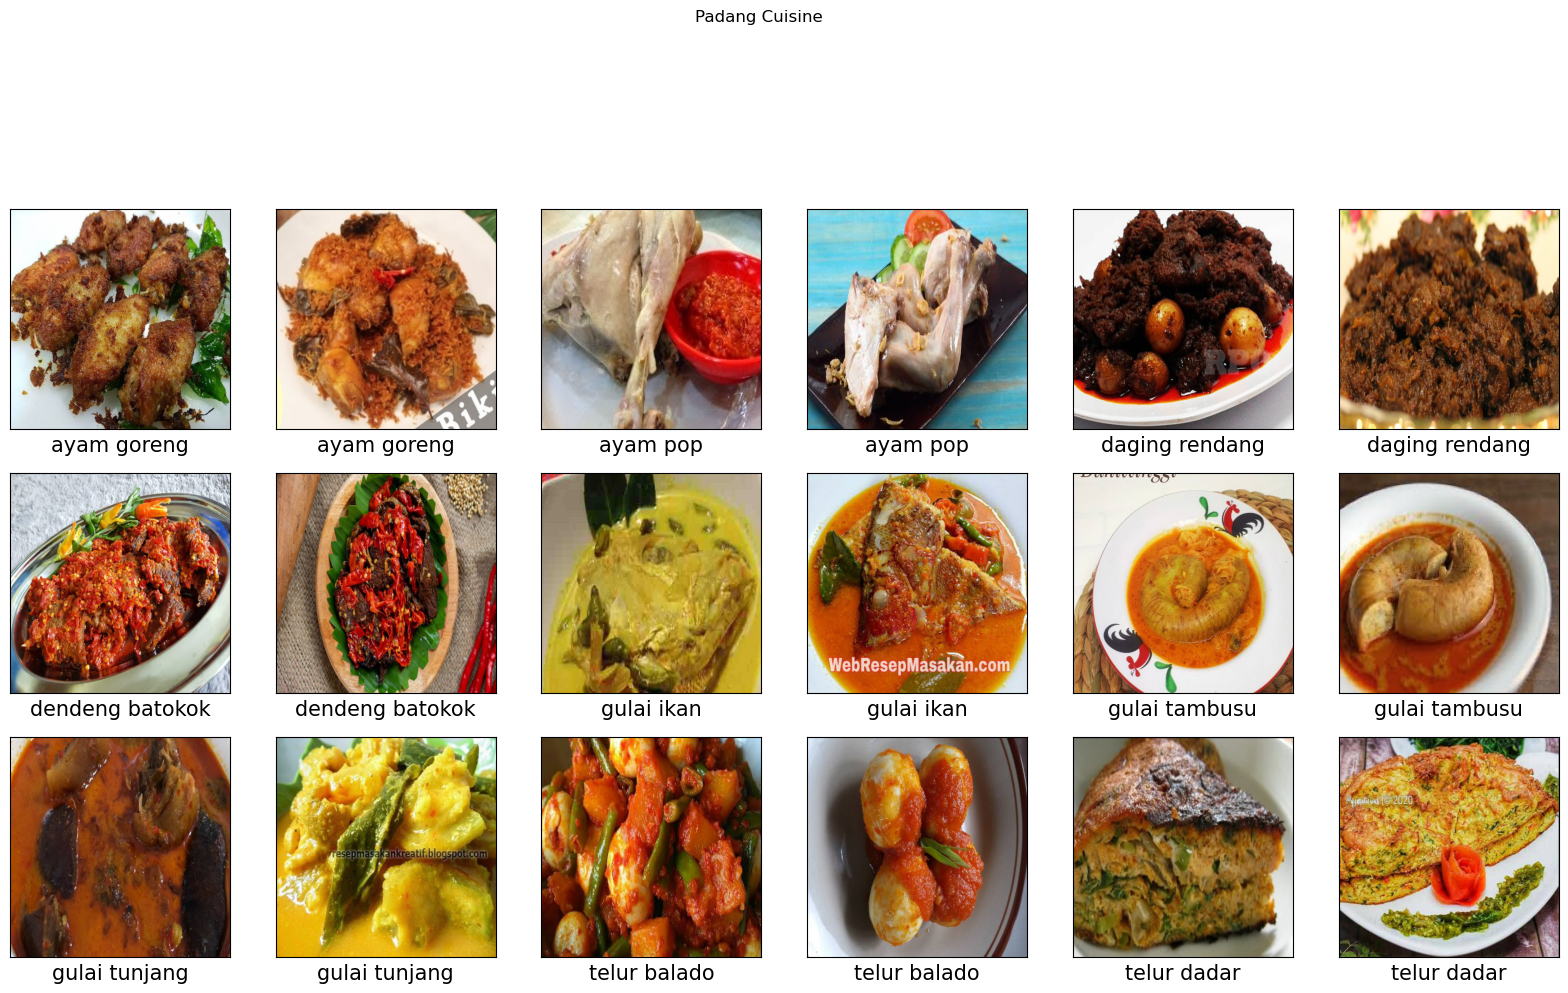

In [49]:
labels  = [(" ").join(x.split('_')) for x in items]

fig = plt.figure(figsize=(20, 20))
fig.suptitle("Padang Cuisine")
i = 1

for path in train_dir:
    for j in range(2) :
        img = imread(path+os.listdir(path)[j])
        size = min(img.shape[0], img.shape[1])
        img = cv2.resize(img, (size,size))
        plt.subplot(6,6,i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(labels[int((i-1)/2)], fontsize=15)
        i += 1
plt.show()

# Feature Engineering

In [51]:
# add Augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,       # Horizontal flipping
    vertical_flip=True,         # Vertical flipping
    rotation_range=90,          # Rotate image counter-clockwise and clockwise up to 90 degrees
    brightness_range=[0.2, 1.0], # Randomly darken or lighten images
    shear_range=0.2,            # Apply shearing transformation
    width_shift_range=0.2,      # Shift images horizontally
    height_shift_range=0.2,     # Shift images vertically
    zoom_range=0.2              # Zoom images
)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_gen = train_datagen.flow_from_directory(
    "datasplit/train",
    target_size=(150, 150),
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    "datasplit/val",
    target_size=(150, 150),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    "datasplit/test",
    target_size=(150, 150),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)


Found 691 images belonging to 9 classes.


Found 194 images belonging to 9 classes.
Found 108 images belonging to 9 classes.


In [52]:
print(train_gen.class_indices)
print(val_gen.class_indices)

{'ayam_goreng': 0, 'ayam_pop': 1, 'daging_rendang': 2, 'dendeng_batokok': 3, 'gulai_ikan': 4, 'gulai_tambusu': 5, 'gulai_tunjang': 6, 'telur_balado': 7, 'telur_dadar': 8}
{'ayam_goreng': 0, 'ayam_pop': 1, 'daging_rendang': 2, 'dendeng_batokok': 3, 'gulai_ikan': 4, 'gulai_tambusu': 5, 'gulai_tunjang': 6, 'telur_balado': 7, 'telur_dadar': 8}


In [53]:
np.random.randint(len(train_gen.next()[0]), size=16)

array([13, 25, 14, 21, 13, 14, 26, 22, 14, 31, 21, 20, 19, 13,  2, 26])

# Model Definition

In [63]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))

model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))

# Adjust the number of units in the output layer to match the number of classes
num_classes = 9  # Change this to the actual number of classes in your problem
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Use 'categorical_crossentropy' if labels are one-hot encoded, or 'sparse_categorical_crossentropy' if labels are integers
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [64]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 36, 36, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)      

In [65]:
history = model.fit(train_gen, epochs=20, validation_data=val_gen)

Epoch 1/20
22/22 [==============================] - 49s 2s/step - loss: 2.1924 - accuracy: 0.1274 - val_loss: 2.1617 - val_accuracy: 0.1392
Epoch 2/20
22/22 [==============================] - 34s 2s/step - loss: 2.0705 - accuracy: 0.2402 - val_loss: 1.8434 - val_accuracy: 0.2887
Epoch 3/20
22/22 [==============================] - 34s 2s/step - loss: 1.7704 - accuracy: 0.3126 - val_loss: 1.6521 - val_accuracy: 0.3454
Epoch 4/20
22/22 [==============================] - 34s 2s/step - loss: 1.6628 - accuracy: 0.3343 - val_loss: 1.6147 - val_accuracy: 0.3402
Epoch 5/20
22/22 [==============================] - 34s 2s/step - loss: 1.6758 - accuracy: 0.3386 - val_loss: 1.5643 - val_accuracy: 0.3247
Epoch 6/20
22/22 [==============================] - 33s 2s/step - loss: 1.6390 - accuracy: 0.3444 - val_loss: 1.5908 - val_accuracy: 0.3711
Epoch 7/20
22/22 [==============================] - 35s 2s/step - loss: 1.6330 - accuracy: 0.3589 - val_loss: 1.5393 - val_accuracy: 0.3247
Epoch 8/20
22/22 [==

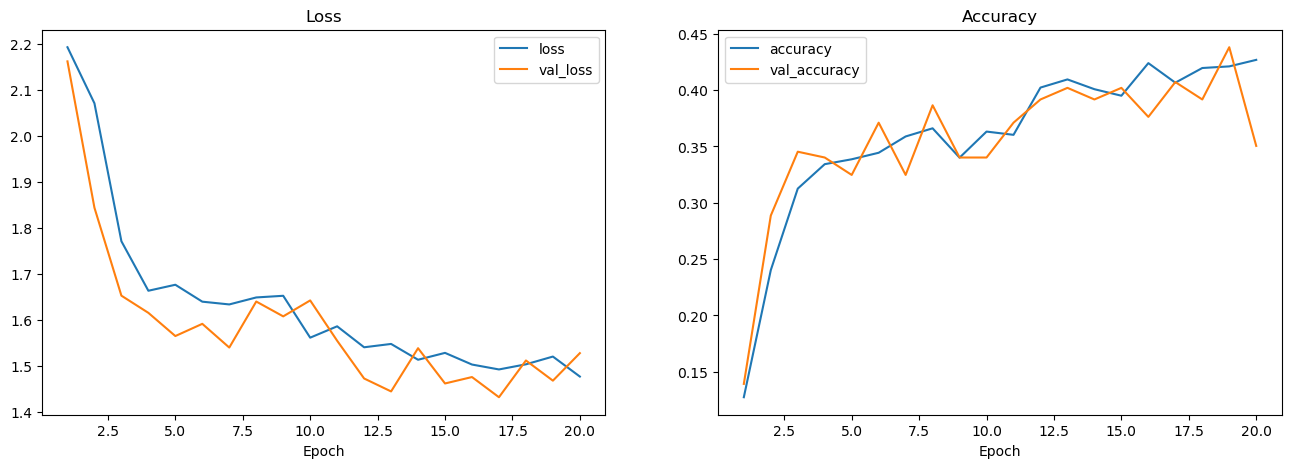

In [67]:
# history plot model
epoch = 20

fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
ax[0].plot(range(1, epoch + 1), history.history['loss'], label='loss')
ax[0].plot(range(1, epoch + 1), history.history['val_loss'], label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1, epoch + 1), history.history['accuracy'], label='accuracy')
ax[1].plot(range(1, epoch + 1), history.history['val_accuracy'], label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()
